# 分析用ノートブック

## 必要なライブラリインポートと仮名簿の作成

In [2]:
import random
import os
import csv
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

In [3]:
# 仮のメンバーリストを作成する

random.seed(1209)
myouzi_alp = ["A", "B", "C", "D", "E", "F", "G"]
myouzi_sita = ["山", "木", "森", "村", "坂"]
syokusyu = ["フォークリフト", "荷下ろし", "荷積", "検品"]

member_list = []
for i in range(len(myouzi_alp)):
    for j in  range(len(myouzi_sita)):
        member_list.append(myouzi_alp[i] + myouzi_sita[j])

# with open('member.csv', 'w') as f:
#     writer = csv.writer(f)
#     for m in member_list:
#         writer.writerow([m, random.choice(syokusyu)])

# 分析

完全にランダムにチームを作成すると、同じグループになる回数に偏りが生まれそうなので自分なりにそれの解決策を考えた。   
　　　

方向性としては、
1. 仮の名簿(A山さん、E木さんなどなど)を作成する
2. 社員2人全ての組み合わせを記録するためのCSVファイルを作成する
3. チーム案(アイランド形式を意識して4人を5グループ、5人を3グループ)を作成する
4. 同じグループに入ったことのあるペアを損失と考え、作成したチーム案の損失を計算する
5. 3-4を繰り返し、最も損失の低いチーム案を採用する
   　

20日間（1ヶ月の勤務日数）で同じグループになった回数を、完全ランダム/最適化の努力済みで比較する。

In [ ]:
import random
import os
import csv
import itertools

def make_team(team_num, names):
    # チームの数とチームメンバーの名前を引数に、チーム案の一つを返す関数

    team_names = names.copy()
    team_list = []
    for t in range(len(team_num)):
        temp_team = random.sample(team_names, team_num[t])
        team_list.append(temp_team)
        for re in range(team_num[t]):
            team_names.remove(temp_team[re])

    return team_list

def asses_team(team_list, pair_count):
    # チームのリストとこれまで一緒のチームに入った回数を引数に、一緒のチームに入った回数(=損失)を計算する関数

    pair_count_dict = {
        frozenset([a, b]): count for a, b, count in pair_count
    }

    losses = 0

    for team in team_list:
        team_pairs = itertools.combinations(team, 2)
        for a, b in team_pairs:
            key = frozenset([a, b])
            losses += pair_count_dict.get(key, 0) 
    return losses


def commit_change(team_list,now_paircount):
    # チーム案を引数に取り、ペアになった回数をCSVファイルに記録する関数

    # まだペアのカウントを行ったことがない場合、ペアの全組み合わせをCSVファイルに入力する
    if now_paircount == []:
        name_course = []
        with open('member.csv', encoding='utf-8') as f:
            reader = csv.reader(f)
            for row in reader:
                if len(row) == 2:
                    name_course.append([row[0].strip(), row[1].strip()])
        names = [member[0] for member in name_course]
        member_pair = {frozenset(pair) for pair in itertools.combinations(names, 2)}
        member_pair_list = [list(pair) for pair in member_pair]
        for member in member_pair_list:
            member.append(0)
        with open('pair_count.csv', 'w') as f:
            writer = csv.writer(f)   
            for m in member_pair_list:
                writer.writerow(m)
        now_paircount = []
        with open('pair_count.csv', encoding='utf-8') as f:
            reader = csv.reader(f)
            for row in reader:
                # 空行を除外し、2列ある行だけ追加
                now_paircount.append([row[0].strip(), row[1].strip(), int(row[2])])
        

    # 今回ペアになった組みあせをCSVファイルに記録する
    pairs = []
    for team in team_list:
        temp_pairs = {frozenset(pair) for pair in itertools.combinations(team, 2)}
        pairs.extend(temp_pairs)
    pairs_thistime_list = [list(pair) for pair in pairs]
    pairs_dict = {frozenset([a, b]): count for a, b, count in now_paircount}
    # ペアになった回数を+1する
    for a, b in pairs_thistime_list:
        key = frozenset([a, b])
        pairs_dict[key] += 1

    # 最後にCSVファイルに今回の結果を書き込んで処理を終了する
    updated_pairs_count = [[*pair, count] for pair, count in pairs_dict.items()]
    with open('pair_count.csv', 'w') as f:
        writer = csv.writer(f)
        for m in updated_pairs_count:
            writer.writerow(m)



if __name__ == '__main__':
    # 名簿が入ったCSVファイルから、名前をリスト形式にする
    name_course = []
    with open('member.csv', encoding='utf-8') as f:
        reader = csv.reader(f)
        for row in reader:
            # 空行を除外し、2列ある行だけ追加
            if len(row) == 2:
                name_course.append([row[0].strip(), row[1].strip()])
    names = [member[0] for member in name_course]


    # 現在までにペアになったことのある回数を取得する
    pair_count = []
    with open('pair_count.csv', encoding='utf-8') as f:
        reader = csv.reader(f)
        for row in reader:
            pair_count.append([row[0].strip(), row[1].strip(), int(row[2])])


    # 1000回試行し、最も一緒のチームに入った回数(=損失)が最も小さいグループを最良のグループとして提案する

    ####       チームそれぞれのメンバー数を入力
    team_num = [4, 4, 4, 4, 4, 5, 5, 5]
    ####

    try:
        if sum(team_num) != len(names):
            raise ValueError(f"メンバー数が一致しません。team_num の合計: {sum(team_num)}, names の数: {len(names)}")
        for i in range(1000):
            if i == 0:
                best_team = make_team(team_num, names)
                temp_best_loss = asses_team(best_team, pair_count) 
            else:
                temp_team_prop = make_team(team_num , names)
                if asses_team(temp_team_prop, pair_count) < temp_best_loss:
                    best_team = temp_team_prop
                    temp_best_loss = asses_team(temp_team_prop, pair_count)
                    print(i, temp_best_loss, temp_team_prop)

        # best_team を CSV に保存
        with open('best_team_proposal.csv', 'w', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            for team in best_team:
                writer.writerow(team)

        print("最良チーム案:")
        for i, team in enumerate(best_team, start=1):
            team_str = ", ".join(team)
            print(f"チーム{i}: {team_str}")
        commit_change(best_team,pair_count)
        
    except Exception as e:
        print("エラーが発生しました:", e)

In [3]:
for i in range(20):
    %run group_opt.py
    %run group_rand.py
df_optimized = pd.read_csv("pair_count.csv", names=["名前1", "名前2", "カウント"])
df_random = pd.read_csv("pair_count_rand.csv", names=["名前1", "名前2", "カウント"])

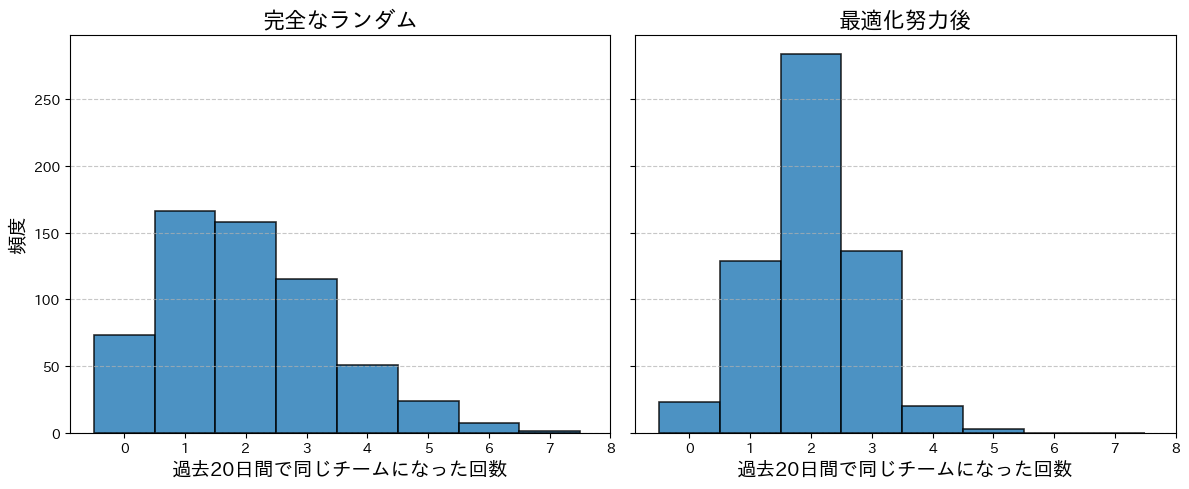

In [5]:
data_random = df_random['カウント']
data_opt   = df_optimized['カウント']

# ビンの範囲を両方で揃える
min_bin = min(data_random.min(), data_opt.min())
max_bin = max(data_random.max(), data_opt.max())
bins    = range(int(min_bin), int(max_bin) + 2)

# 1行2列のサブプロット
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=True)

# --- 左：完全なランダム ---
axes[0].hist(
    data_random,
    bins=bins,
    align='left',
    edgecolor='black',
    linewidth=1.2,
    alpha=0.8
)
axes[0].set_title('完全なランダム', fontsize=16)
axes[0].set_xlabel('過去20日間で同じチームになった回数', fontsize=14)
axes[0].set_ylabel('頻度', fontsize=14)
axes[0].set_xticks(bins)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# --- 右：最適化努力後 ---
axes[1].hist(
    data_opt,
    bins=bins,
    align='left',
    edgecolor='black',
    linewidth=1.2,
    alpha=0.8
)
axes[1].set_title('最適化努力後', fontsize=16)
axes[1].set_xlabel('過去20日間で同じチームになった回数', fontsize=14)
axes[1].set_xticks(bins)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()